<a href="https://colab.research.google.com/github/lewin-jesudhas/Sleep-Stage-Classification/blob/main/analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: Connect drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prompt: There is a file called physionet.org on my drive, i need to make that my directory

import os

os.chdir('/content/drive/MyDrive/physionet.org')

In [8]:
!pip install mne
!pip install Pywavelets
import mne
import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Directory paths
edf_dir = r'/content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordings'  # Replace with the actual path to your EDF files
annotation_dir = r'/content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordings'  # Replace with the actual path to your annotation files

# Initialize lists to store features and labels
all_wavelet_features = []
all_labels = []

# Define the wavelet transform function
def compute_wavelet_features(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # Extract statistics from each wavelet level (mean, std deviation)
    features = [np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs]
    return features

# Iterate over each EDF and annotation file pair
for i in range(1, 155):  # Adjust range for files from SN001 to SN154
    if i == 138:
        continue  # Skip SN138

    # Format the index to include leading zeros
    file_index = f'{i:03}'  # Ensures the file index has three digits, e.g., 001, 002, ..., 154
    edf_file = os.path.join(edf_dir, f'SN{file_index}.edf')
    annotation_file = os.path.join(annotation_dir, f'SN{file_index}_sleepscoring.txt')



    # Load EDF file
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    raw.crop(tmin=150, tmax=raw.times[-1] - 150)  # Crop 150s from start and end
    raw.filter(0.5, 30, fir_design='firwin')  # Bandpass filter
    raw.resample(100)  # Resample

    # Load and process annotation file
    annotations_df = pd.read_csv(annotation_file)
    annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]
    annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
    annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')

    # Filter annotations to fit within the cropped data range and adjust onset
    total_duration = raw.times[-1] - 150 * 2
    filtered_annotations_df = annotations_df[
        (annotations_df['Recording onset'] >= 150) &
        (annotations_df['Recording onset'] <= total_duration)
    ].copy()
    filtered_annotations_df['Recording onset'] -= 150

    # Set annotations
    annotations = mne.Annotations(
        onset=filtered_annotations_df['Recording onset'].values,
        duration=filtered_annotations_df['Duration'].values,
        description=filtered_annotations_df['Annotation'].values
    )
    raw.set_annotations(annotations)

    # Create events and epochs
    events, event_id = mne.events_from_annotations(raw)
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=30, baseline=None, preload=True)

    # Encode labels
    labels = epochs.events[:, -1]
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    # Wavelet feature extraction
    eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_timepoints)
    wavelet_features = []
    for epoch in eeg_data:
        for channel_data in epoch:
            features = compute_wavelet_features(channel_data)
            wavelet_features.append(features)
    wavelet_features = np.array(wavelet_features)
    wavelet_features = wavelet_features.reshape(len(labels), -1)  # Reshape for ML input

    # Append to the main lists
    all_wavelet_features.extend(wavelet_features)
    all_labels.extend(labels)




Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordings/SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
830 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 830 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/M

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
832 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 832 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
930 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 930 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
992 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 992 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
935 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 935 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
842 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 842 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1010 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1010 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
823 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 823 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
877 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 877 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 900 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1117 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1117 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
913 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 913 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
980 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 980 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
700 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 700 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
843 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 843 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1064 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1064 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1090 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1090 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 838 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
816 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 816 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
924 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 924 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
932 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 932 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
978 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 978 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
767 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 767 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
833 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 833 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
966 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 966 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
859 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 859 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
848 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 848 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
878 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 878 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
927 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 927 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1032 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1032 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
749 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 749 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1164 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1164 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordings/SN033.edf...


<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
498 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 498 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordings/SN034.edf...
ED

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
863 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 863 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
972 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 972 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
784 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 784 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
806 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 806 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
903 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 903 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
863 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 863 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 777 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
813 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 813 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1126 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1126 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
990 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 990 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
947 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 947 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 691 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
687 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 687 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
860 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 860 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1232 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 777 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
908 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 908 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
905 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 905 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
987 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 987 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
916 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 916 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
474 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 474 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
971 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 971 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1129 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
752 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 752 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1025 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1025 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
802 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 802 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
918 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 918 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 838 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R']
Not setting metadata
446 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 446 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordings/SN063.edf...
E

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1216 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
706 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 706 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1015 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1015 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
986 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 986 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
942 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 942 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
817 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 817 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
713 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 713 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
648 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 648 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1066 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1066 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1034 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1034 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
867 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 867 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
821 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 821 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1065 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1065 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
663 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 663 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
830 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 830 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
850 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 850 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1093 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1093 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
865 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 865 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1124 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1124 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
721 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 721 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1063 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1063 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
852 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 852 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
982 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 982 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
673 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 673 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
811 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 811 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
982 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 982 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
782 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 782 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
883 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 883 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
728 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 728 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1005 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1005 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
754 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 754 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1026 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1026 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 838 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
692 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 692 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1026 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1026 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
851 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 851 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
823 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 823 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 881 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
895 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 895 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
816 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 816 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 960 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
983 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 983 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
814 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 814 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 651 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
729 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 729 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
858 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 858 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
759 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 759 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
937 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 937 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1053 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1053 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage W']
Not setting metadata
824 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 824 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordings/SN113.edf...
E

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
868 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 868 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
585 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 585 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
833 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 833 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
773 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 773 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
737 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 737 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
972 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 972 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
892 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 892 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
789 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 789 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1059 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1059 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
821 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 821 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
725 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 725 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1012 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1012 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1178 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1178 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
775 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 775 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
937 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 937 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
902 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 902 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
840 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 840 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 490 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
937 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 937 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
995 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 995 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
971 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 971 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1155 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
885 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 885 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordings/SN136.edf...
ED

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 672 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1045 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1045 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
708 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 708 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1287 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1287 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
1041 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1041 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recor

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
884 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 884 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
918 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 918 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
769 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 769 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
761 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 761 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Reading 0 ... 7849471  =      0.000 ... 30661.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
998 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 998 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/M

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
880 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 880 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
842 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 842 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
839 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 839 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
565 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 565 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
820 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 820 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
975 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 975 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
878 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 878 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/MyDrive/physionet.org/files/hmc-sleep-staging/1.0.0/recordi

<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
<ipython-input-8-8e3a47c9c450>:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [' Sleep stage N1', ' Sleep stage N2', ' Sleep stage N3', ' Sleep stage R', ' Sleep stage W']
Not setting metadata
979 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 979 events and 3001 original time points ...
0 bad epochs dropped


Model training completed.
Accuracy: 0.7752846493342729
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.31      0.41      3119
           1       0.76      0.85      0.80      9994
           2       0.86      0.81      0.83      5280
           3       0.79      0.79      0.79      4269
           4       0.76      0.89      0.82      4301

    accuracy                           0.78     26963
   macro avg       0.76      0.73      0.73     26963
weighted avg       0.77      0.78      0.76     26963



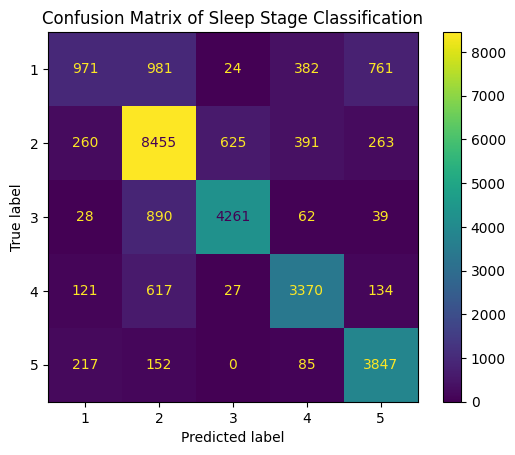

Cross-Validation Scores: [0.62596892 0.61213515 0.61265438 0.62926974 0.57640383]
Average CV Score: 0.6112864028767393


In [9]:
# Convert lists to arrays for ML
all_wavelet_features = np.array(all_wavelet_features)
all_labels = np.array(all_labels)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix of Sleep Stage Classification")
plt.show()

# 5-fold cross-validation
cv_scores_rf = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)
print("Cross-Validation Scores:", cv_scores_rf)
print("Average CV Score:", np.mean(cv_scores_rf))


In [11]:
#!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam

# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(all_wavelet_features.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(len(label_encoder.classes_), activation='softmax')  # One output per sleep stage
])

# Compile the model
model.compile(optimizer=Nadam(learning_rate=0.001),  # Adjust learning rate if necessary
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.25,
                    callbacks=[early_stopping])

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.3212 - loss: 1.6599 - val_accuracy: 0.5501 - val_loss: 1.1304
Epoch 2/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5245 - loss: 1.1604 - val_accuracy: 0.6174 - val_loss: 1.0130
Epoch 3/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5629 - loss: 1.0924 - val_accuracy: 0.6076 - val_loss: 0.9780
Epoch 4/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.5861 - loss: 1.0501 - val_accuracy: 0.4208 - val_loss: 1.4306
Epoch 5/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5932 - loss: 1.0286 - val_accuracy: 0.4783 - val_loss: 1.5692
Epoch 6/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6021 - loss: 1.0071 - val_accuracy: 0.4576 - val_loss: 1.4627
Epoch 7/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.6107 - loss: 0.9885 - val_accuracy: 0.2470 - val_loss: 3.4599
Epoch 8/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.6072 -

In [13]:
# prompt: How do i pickle this so that I dont need to keep running the whole code again and again and I can directly load the status from the pickle file

import pickle

# Assuming you have your trained model (clf) and other relevant data like label_encoder
# ... (your existing code) ...


# Save the trained model and label encoder to a pickle file
model_filename = 'sleep_stage_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump({'model': clf, 'label_encoder': label_encoder}, file)

print(f"Model and label encoder saved to {model_filename}")

# ... (rest of your code) ...

# To load the pickled model later:

# model_filename = 'sleep_stage_model.pkl'
# with open(model_filename, 'rb') as file:
#     loaded_data = pickle.load(file)

# loaded_model = loaded_data['model']
# loaded_label_encoder = loaded_data['label_encoder']

# Now you can use loaded_model and loaded_label_encoder for predictions, etc.

Model and label encoder saved to sleep_stage_model.pkl


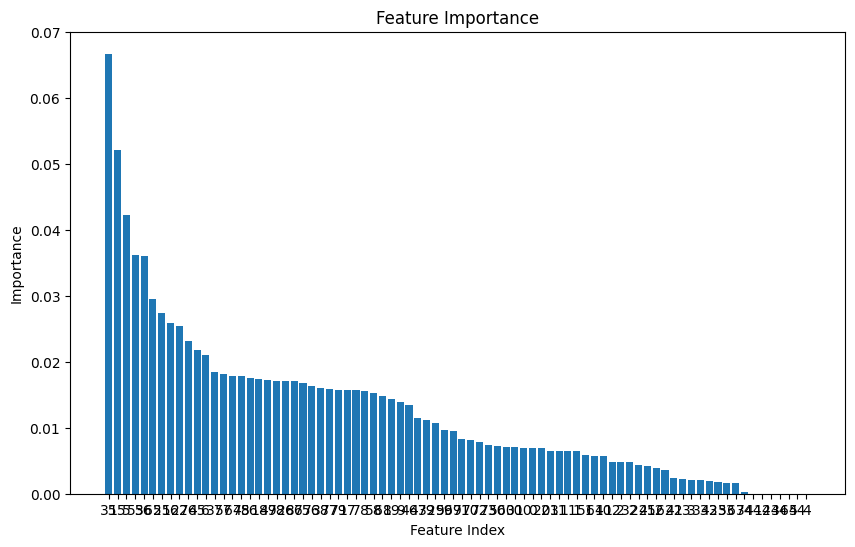

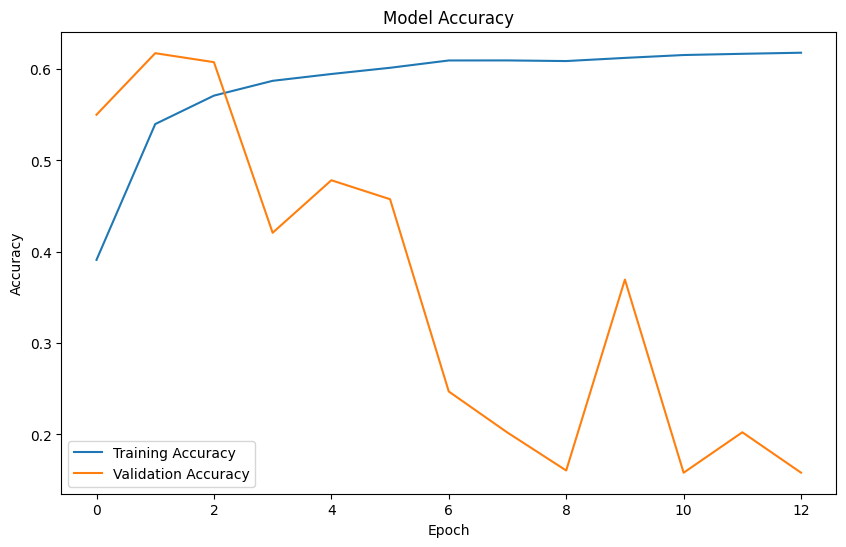

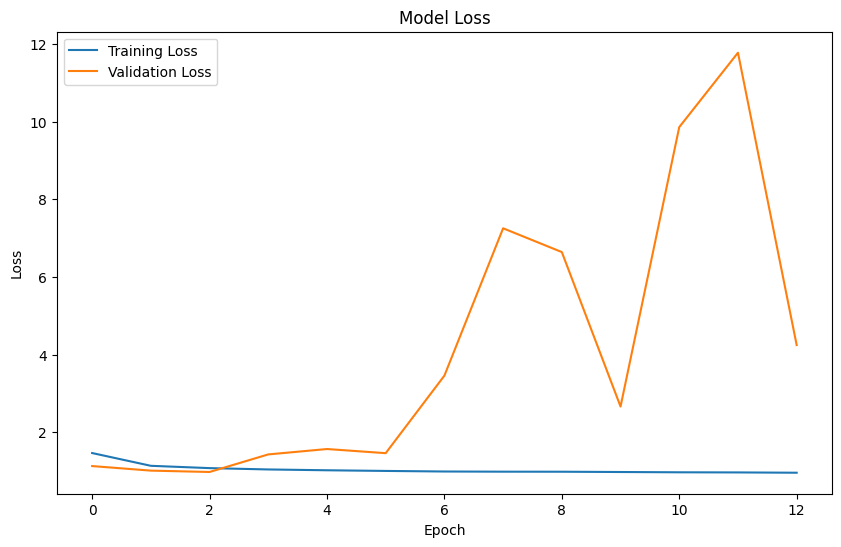

In [14]:
# prompt: I need some data visualization graphs for my data

# Assuming you have your trained model (clf) and other relevant data like label_encoder
# ... (your existing code) ...

# Feature importance plot for Random Forest
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Training and Validation Accuracy/Loss Plot for Neural Network
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# You can add more visualizations based on your specific needs,
# such as:
# - Distribution of sleep stages in the dataset
# - Scatter plots of features
# - Correlation matrix of features
# - ...

# ... (rest of your code) ...

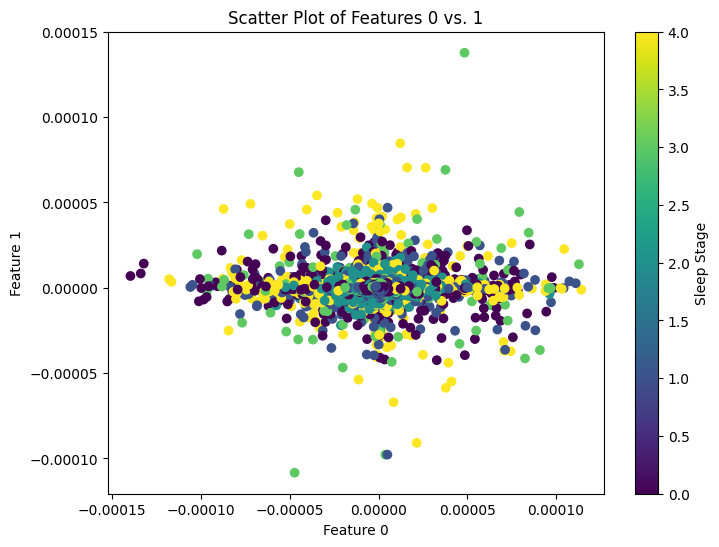

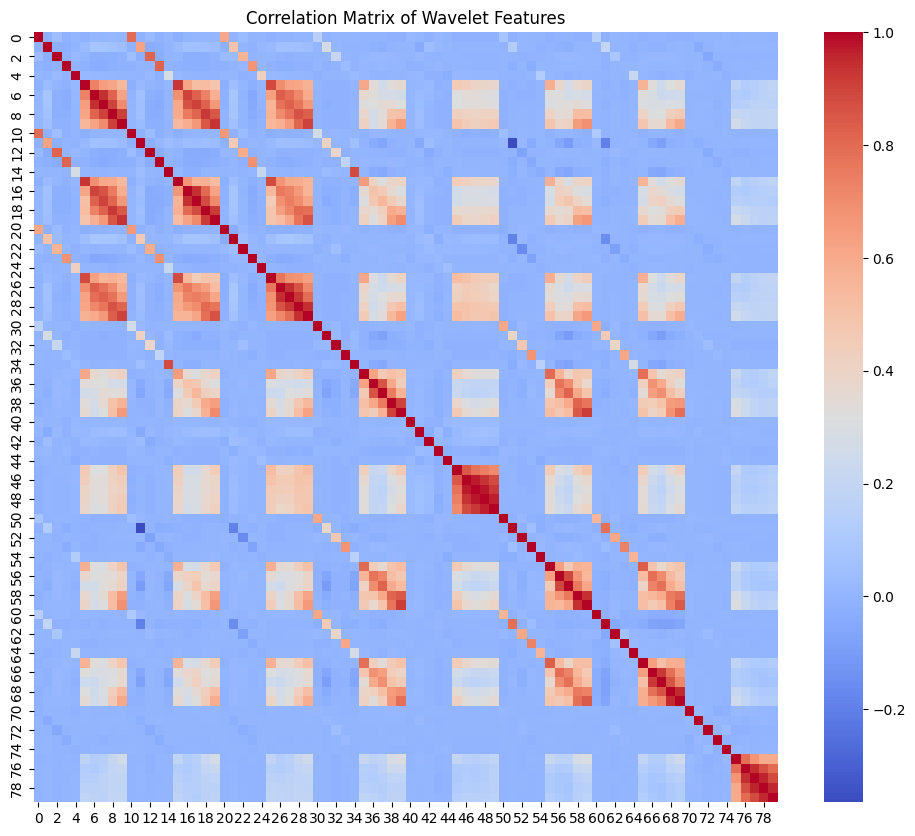

In [16]:
# prompt: Can you give scatterplot and corellation matrix for my code

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your feature data (all_wavelet_features) and labels (all_labels)
# ... (your existing code) ...

# Scatter plot (example: feature 0 vs. feature 1)
plt.figure(figsize=(8, 6))
plt.scatter(all_wavelet_features[:, 0], all_wavelet_features[:, 1], c=all_labels, cmap='viridis')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Scatter Plot of Features 0 vs. 1')
plt.colorbar(label='Sleep Stage')
plt.show()


# Correlation matrix
correlation_matrix = np.corrcoef(all_wavelet_features, rowvar=False)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Wavelet Features')
plt.show()

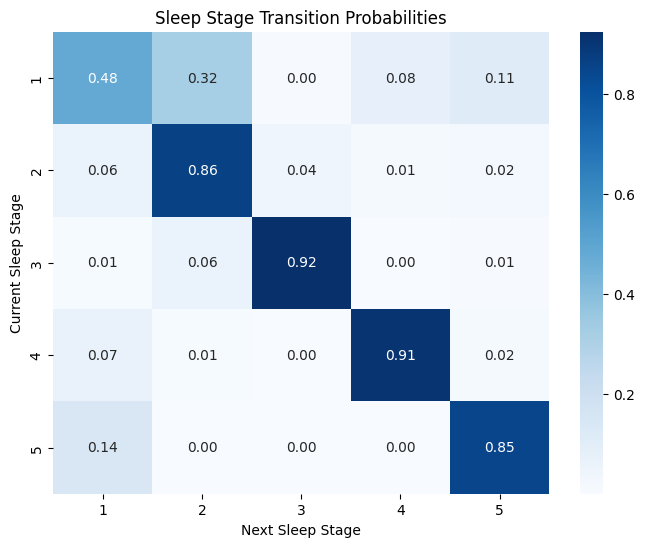

In [17]:
# prompt: Is there any graph analytics I can give

# Assuming you have your feature data (all_wavelet_features) and labels (all_labels)
# ... (your existing code) ...

# Create a graph (adjacency matrix) representing relationships between sleep stages
# You can define the relationships based on transitions between stages
# (e.g., how often does stage 1 transition to stage 2?).

# Example: Build a transition matrix
num_stages = len(np.unique(all_labels))
transition_matrix = np.zeros((num_stages, num_stages))
for i in range(len(all_labels) - 1):
  current_stage = all_labels[i]
  next_stage = all_labels[i + 1]
  transition_matrix[current_stage, next_stage] += 1

# Normalize the transition matrix (optional)
row_sums = transition_matrix.sum(axis=1)
transition_matrix = transition_matrix / row_sums[:, np.newaxis]

# Visualize the transition matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Next Sleep Stage')
plt.ylabel('Current Sleep Stage')
plt.title('Sleep Stage Transition Probabilities')
plt.show()


# You can also consider using networkx library for more advanced graph analysis:
# !pip install networkx

# import networkx as nx

# # Create a graph from the transition matrix
# G = nx.DiGraph()
# for i in range(num_stages):
#   for j in range(num_stages):
#     if transition_matrix[i, j] > 0:
#       G.add_edge(i, j, weight=transition_matrix[i, j])

# # Perform graph analysis, e.g., centrality measures, shortest paths, etc.
# ...

# ... (rest of your code) ...

In [ ]:
# prompt: Explain the above transition probabilities graph

The code you provided generates a heatmap representing the **Sleep Stage Transition Probabilities**. Let's break down what it does and how to interpret the resulting graph:


1. **Transition Matrix Calculation:**
   - The code iterates through the sequence of sleep stages (labels) from your dataset.
   - For each pair of consecutive stages (current stage and next stage), it increments the corresponding cell in a `transition_matrix`.
   - This matrix essentially counts how often each sleep stage transitions to another stage.

2. **Normalization (Optional):**
   - The code normalizes the `transition_matrix` by dividing each row by its sum. This converts the counts into probabilities. Each cell in the normalized matrix now represents the probability of transitioning from the row's stage to the column's stage.


3. **Visualization (Heatmap):**
   - The code then creates a heatmap using the Seaborn library.
   - The rows and columns of the heatmap correspond to the different sleep stages (e.g., Wake, N1, N2, N3, REM).
   - The color intensity in each cell represents the probability of transitioning from the row's stage to the column's stage.


**Interpretation of the Graph:**


- **Diagonal Cells:** The diagonal cells (where row index equals column index) represent the probability of staying in the same sleep stage. A high value on the diagonal means the model is likely to predict that the person will remain in that stage.
- **Off-Diagonal Cells:** The off-diagonal cells represent the probability of transitioning to a different sleep stage. Higher values indicate a higher likelihood of transition between those stages. For example, a high value in the cell representing the transition from N1 to N2 means that it's quite probable for a person to transition from stage N1 to stage N2.
- **Darker Colors:** Darker colors (blue in the example) typically indicate higher probabilities.
- **Lighter Colors:** Lighter colors indicate lower probabilities.


**Example Interpretation:**


If the cell for transitioning from N2 to N3 is darker than the cell for transitioning from N2 to REM, it suggests that the person is more likely to progress from N2 to N3 rather than moving into REM sleep.



**In Essence:**


The transition probabilities graph visualizes the common patterns of sleep stage changes observed in your dataset. It helps to understand how the different sleep stages relate to each other in terms of transitions, which can be beneficial for:

* **Sleep Disorder Detection:**  Abnormal transition patterns may be indicative of sleep disorders.
* **Model Evaluation:** It helps to assess if your model accurately captures these transition patterns.
* **Understanding Sleep Architecture:** It provides insight into the natural flow of sleep stages.



I hope this detailed explanation is helpful! Let me know if you have any other questions about the code or the graph.

Degree Centrality: {0: 2.5, 1: 2.5, 2: 2.5, 3: 2.5, 4: 2.5}
Betweenness Centrality: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
Closeness Centrality: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


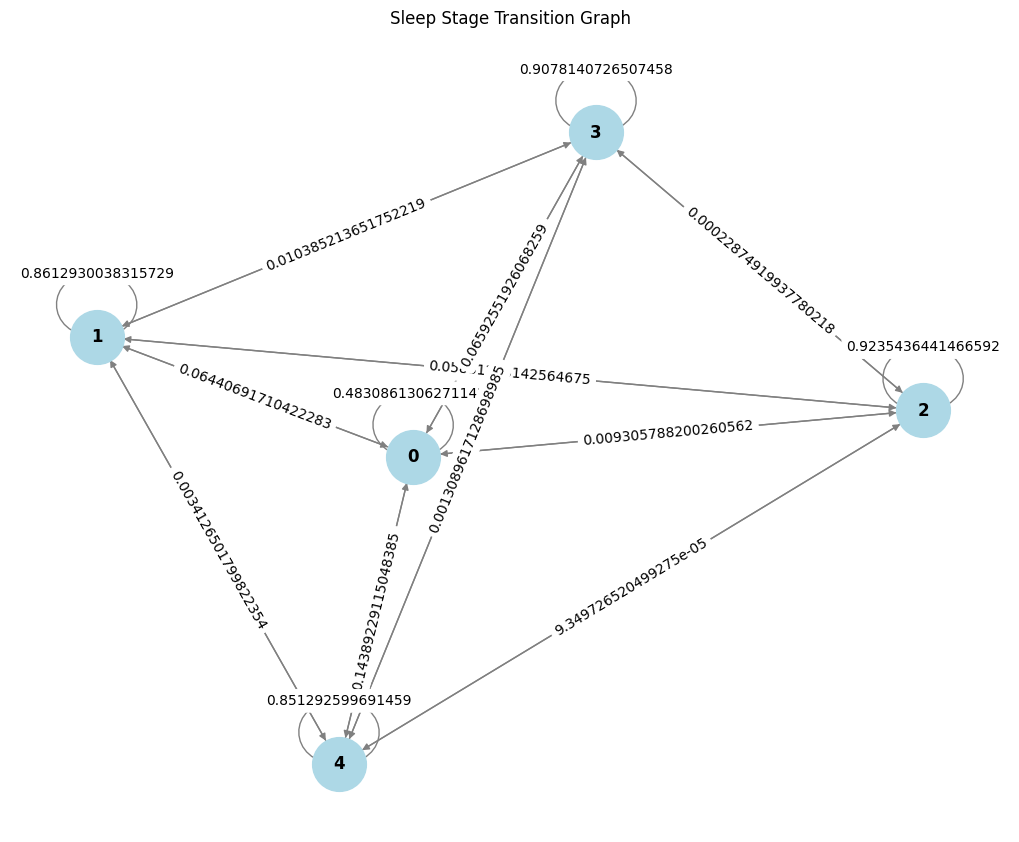

In [25]:
# prompt: use networkx library for more advanced graph analysis:

# ... (your existing code) ...

# Assuming you have your feature data (all_wavelet_features) and labels (all_labels)
# ... (your existing code) ...

# Install networkx if not already installed
!pip install networkx

import networkx as nx

# Create a graph (adjacency matrix) representing relationships between sleep stages
# You can define the relationships based on transitions between stages
# (e.g., how often does stage 1 transition to stage 2?).

# Example: Build a transition matrix
num_stages = len(np.unique(all_labels))
transition_matrix = np.zeros((num_stages, num_stages))
for i in range(len(all_labels) - 1):
  current_stage = all_labels[i]
  next_stage = all_labels[i + 1]
  transition_matrix[current_stage, next_stage] += 1

# Normalize the transition matrix (optional)
row_sums = transition_matrix.sum(axis=1)
transition_matrix = transition_matrix / row_sums[:, np.newaxis]

# Create a graph from the transition matrix
G = nx.DiGraph()
for i in range(num_stages):
  for j in range(num_stages):
    if transition_matrix[i, j] > 0:
      G.add_edge(i, j, weight=transition_matrix[i, j])

# Perform graph analysis, e.g., centrality measures, shortest paths, etc.
# Example: Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
print("Degree Centrality:", degree_centrality)

# Example: Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
print("Betweenness Centrality:", betweenness_centrality)

# Example: Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)
print("Closeness Centrality:", closeness_centrality)


# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # You can choose different layout algorithms
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500,
        edge_color='gray', font_size=12, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Sleep Stage Transition Graph')
plt.show()

# ... (rest of your code) ...

In [ ]:
# prompt: Explain the above Networkx graph

Okay, let's dissect the NetworkX graph part of the code and understand what it represents within the context of sleep stage analysis.


**Purpose of the Graph**


The code aims to construct a directed graph (using the NetworkX library) where:


* **Nodes:** Represent different sleep stages (e.g., Wake, N1, N2, N3, REM).
* **Edges:** Represent transitions between sleep stages. The edge weight indicates the probability of transitioning from one stage to another.


**How the Graph is Created**


1. **Transition Matrix:**
   - The code first calculates a `transition_matrix`.
   - This matrix stores the number of times each sleep stage transitions to another stage.
   - Each cell `(i, j)` in the matrix represents the number of times sleep stage `i` transitions to sleep stage `j`.

2. **Normalization:**
   - Optionally, the matrix is normalized by dividing each row by its sum.
   - This transforms the counts into probabilities, indicating the likelihood of transitioning from one stage to another.

3. **NetworkX Graph:**
   - The code then creates a directed graph `G` using the `networkx.DiGraph()` function.
   - For each non-zero entry in the `transition_matrix`, an edge is added between the corresponding nodes in the graph.
   - The edge's weight is set to the transition probability from the matrix.


**What the Graph Represents**


The resulting graph visualizes the flow and relationships between different sleep stages. It essentially provides a visual depiction of how frequently a person transitions from one stage to another.


**Example Interpretation**


- If there's a strong edge (high weight) from N2 to N3, it suggests that there's a high probability of transitioning from stage N2 to stage N3 in the dataset.
- Conversely, if there's a weak edge (low weight) between Wake and REM, it means that transitions from Wake to REM are less frequent.


**Centrality Measures**


The code then calculates different centrality measures, which can be helpful for identifying important or influential sleep stages within the graph:


- **Degree Centrality:** Measures how many connections a node has. Nodes with high degree centrality frequently transition to or from other stages.
- **Betweenness Centrality:** Measures how often a node lies on the shortest path between other nodes. Nodes with high betweenness centrality are crucial in transitions between different parts of the graph (sequence of sleep stages).
- **Closeness Centrality:** Measures how close a node is to all other nodes on average. Nodes with high closeness centrality can transition to other stages more efficiently.


**Visualization**


The graph is visualized using the `nx.draw()` function, displaying the nodes and edges of the graph. This visual representation can help identify patterns and trends within sleep stage transitions.


**Applications**


This graph and its analysis can be used to:


* **Analyze sleep patterns:** Identify common sleep stage transition sequences.
* **Detect anomalies:** Unusual transition patterns may be indicative of sleep disorders.
* **Build models:** The graph could be used as input for building models for sleep stage classification or prediction.



I hope this explanation helps you understand the NetworkX graph in the code and its relevance to analyzing sleep stage data! Let me know if you have any more questions.